In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pandas as pd
from modules.representation_schemes import enc1d_features, get_PTR_features
from modules.function import get_metrics, pymatgen_comp, get_elem_count, data_generator_vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
import json
import pickle
import torch
from uncertainties import ufloat
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
phases_file = 'Files_from_GTDL_paper/gao_data.txt'
[x0,dataY]=pickle.load(open(phases_file, 'rb'))
comps = [y.split(' ')[1] for y in x0]
pmg_comps = pymatgen_comp(comps)
y = np.array(dataY)

comp_dict = get_elem_count(comps)
filtered_els = [c for c in comp_dict.keys() if comp_dict[c] >= 40]

In [5]:
with open('misc/pca_components_phase.pkl','rb') as fid: ##95% explained variance
    component_dict = pickle.load(fid)

## Random subsampling

In [6]:
filename = 'misc/hea_phase_random_subsampling_split.json'
create_new = True
if os.path.exists(filename) and not create_new:
    with open(filename,'rb') as fid:
        kfold_dict_random_subsampling = pickle.load(fid)
        print('Split file loaded')
else:
    np.random.seed(0)
    kfold_dict_random_subsampling = {}
    for i in np.geomspace(0.01,0.99,10):
        remove_inds_list = []
        retain_inds_list = []
        to_retain = int(len(comps)*i)
        for j in range(10):
            remaining_inds = np.random.choice(len(comps),to_retain, replace=False)
            remove_inds = list(set(np.arange(len(comps))) - set(remaining_inds))
            remove_inds_list.append(remove_inds)
            retain_inds_list.append(remaining_inds)
        kfold_dict_random_subsampling[np.round(i,2)] = {'remove':remove_inds_list,'retain':retain_inds_list}

    with open(filename,'wb') as fid:
        pickle.dump(kfold_dict_random_subsampling,fid)
    print('Split file written!')

Split file written!


In [11]:
np.random.seed(0)
dset = data_generator_vec(pymatgen_comp(comps))
methods = ['baseline','RF','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
method_dict = {}
for method in methods:
    print(f'{method}')
    if method in ['baseline','RF']:
        features = dset.real_data
    else:
        if method == 'atomic':
            extracted = enc1d_features(pmg_comps,'atomic')
        elif method == 'random':
            extracted = enc1d_features(pmg_comps,'random')
        elif method == 'random-tr':
            extracted = enc1d_features(pmg_comps,'random-tr')
        elif method == 'pettifor':
            extracted = enc1d_features(pmg_comps,'pettifor')
        elif method == 'mod_pettifor':
            extracted = enc1d_features(pmg_comps,'mod_pettifor')
        elif method == 'PTR':
            extracted = get_PTR_features(pmg_comps)
        elif method =='dense':
            extracted = enc1d_features(pmg_comps,'dense')
        ind = component_dict[method]
        pca = PCA(n_components=ind, whiten=True)
        features = pca.fit_transform(extracted)
    random_subsampling_dict = {}
    for k in kfold_dict_random_subsampling.keys():
        holdout_test = kfold_dict_random_subsampling[k]['remove']
        retained = kfold_dict_random_subsampling[k]['retain']
        score=[]
        fold_report = {}
        if method == 'baseline':
            baseline_model = Pipeline([('Scaler', StandardScaler()),('MLPC',MLPClassifier((42,42,42),batch_size=64,random_state=0))])
        else:

            baseline_model = RandomForestClassifier(random_state=0, n_jobs=-1)
        for i, (train_inds, test_inds) in enumerate(zip(*[retained,holdout_test])):
            train_features = features[train_inds]
            train_y = y[train_inds]
            baseline_model.fit(train_features,train_y)
            yte_pred_holdout = baseline_model.predict(features[test_inds])
            report = metrics.classification_report(y[test_inds], yte_pred_holdout,output_dict=True)
            fold_micro_avg = report['weighted avg']['f1-score']
            score.append(fold_micro_avg)
            fold_report['Fold_{}'.format(k)] = report
        random_subsampling_dict[k] = score
    method_dict[method] = random_subsampling_dict
    #print(f'Holdout size : {len(holdout_test)} , F1_score : {ufloat(np.mean(score),np.std(score))}')
#baseline_model = RandomForestClassifier(random_state=0, n_jobs=-1)


baseline
RF
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR


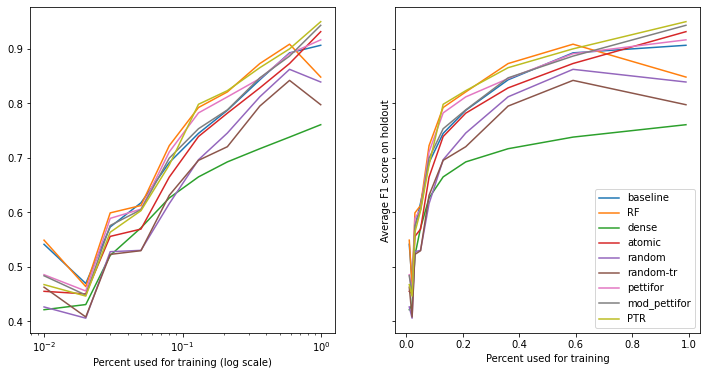

In [12]:
fig,ax  = plt.subplots(1,2,figsize= (12,6), sharey = True)
ax = ax.ravel()
for j,c in enumerate([True,False]):
    for method in method_dict.keys():
        random_subsampling_dict = method_dict[method]
        mean_list = []
        std_list = []
        for i in random_subsampling_dict.keys():
            mean = np.mean(random_subsampling_dict[i])
            std = np.std(random_subsampling_dict[i])
            mean_list.append(mean)
            std_list.append(std)
        ax[j].errorbar(random_subsampling_dict.keys(),mean_list,label = method)
        if c:
                ax[j].set_xlabel('Percent used for training (log scale)')
                ax[j].set_xscale('log')
        else:
                ax[j].set_xlabel('Percent used for training')
plt.ylabel('Average F1 score on holdout')
plt.legend()

## Individual elements as holdout sets

### making the splits for each individual elements

In [24]:
selected_els = ['Al','Ni','Fe','Cr','Ti','Nb','Ta','La','Mg','Mo']
filename = 'misc/hea_phase_gen_splits.json'
create_new = False
if os.path.exists(filename) and not create_new:
    with open(filename,'rb') as fid:
        hea_phase_gen_dict = json.load(fid)
        print('Split file loaded')
else:
    hea_phase_gen_dict = {}
    for el in selected_els:
        train_inds, test_inds,all_cv_train, all_cv_test = [],[],[],[]
        for i,c in enumerate(pmg_comps):
            if el in c.get_el_amt_dict().keys():
                test_inds.append(i)
            else:
                train_inds.append(i)
        X_train = np.array(pmg_comps)[train_inds]
        kf = StratifiedKFold(n_splits=10, random_state=0,shuffle=True).split(X_train,y[train_inds])
        for tr, ts in kf:
            all_cv_train.append(tr.tolist())
            all_cv_test.append(ts.tolist())
        hea_phase_gen_dict[el] = {'train':train_inds,'test':test_inds, 'cv_train':all_cv_train, 'cv_test':all_cv_test}
    with open(filename,'w') as fid:
        json.dump(hea_phase_gen_dict, fid)
        print('Split file written!')

Split file loaded


### training RFC models

#### baseline

In [29]:
from uncertainties import ufloat
np.random.seed(0)
dset = data_generator_vec(pymatgen_comp(comps))
features = dset.real_data
LOEO_dict = {}

for k in hea_phase_gen_dict.keys():
        
        temp_dict = hea_phase_gen_dict[k]
        holdout_test = temp_dict['test']
        cv_train, cv_test = temp_dict['cv_train'], temp_dict['cv_test']
        score=[]
        fold_report = {}
        baseline_model = RandomForestClassifier(random_state=0, n_jobs=-1)
        for i, (train_inds, test_inds) in enumerate(zip(*[cv_train,cv_test])):
                train_features = features[train_inds]
                train_y = y[train_inds]
                baseline_model.fit(train_features,train_y)
                yte_pred=baseline_model.predict(features[test_inds])
                yte_pred_holdout = baseline_model.predict(features[holdout_test])
                report = metrics.classification_report(y[holdout_test], yte_pred_holdout,output_dict=True)
                fold_micro_avg = report['weighted avg']['f1-score']
                score.append(fold_micro_avg)
                fold_report['Fold_{}'.format(k)] = report
        LOEO_dict[k] = {'baseline':score}
        print(f'Element : {k}, Test size : {len(holdout_test)} , F1_score : {ufloat(np.mean(score),np.std(score))}')

Element : Al, Test size : 202 , F1_score : 0.765+/-0.004
Element : Ni, Test size : 248 , F1_score : 0.682+/-0.015
Element : Fe, Test size : 215 , F1_score : 0.839+/-0.012
Element : Cr, Test size : 209 , F1_score : 0.918+/-0.008
Element : Ti, Test size : 117 , F1_score : 0.737+/-0.007
Element : Nb, Test size : 58 , F1_score : 0.874+/-0.008
Element : Ta, Test size : 30 , F1_score : 0.986+/-0.024
Element : La, Test size : 13 , F1_score : 0.98+/-0.04
Element : Mg, Test size : 15 , F1_score : 0.98+/-0.04
Element : Mo, Test size : 60 , F1_score : 0.874+/-0.010


#### representations transfer

In [30]:
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
for k in hea_phase_gen_dict.keys():
    temp_dict = hea_phase_gen_dict[k]
    holdout_test = temp_dict['test']
    cv_train, cv_test = temp_dict['cv_train'], temp_dict['cv_test']
    temp_dict = {}
    for i, method in enumerate(methods):
        score=[]
        fold_report = {}
        if method == 'atomic':
            extracted = enc1d_features(pmg_comps,'atomic')
        elif method == 'random':
            extracted = enc1d_features(pmg_comps,'random')
        elif method == 'random-tr':
            extracted = enc1d_features(pmg_comps,'random-tr')
        elif method == 'pettifor':
            extracted = enc1d_features(pmg_comps,'pettifor')
        elif method == 'mod_pettifor':
            extracted = enc1d_features(pmg_comps,'mod_pettifor')
        elif method == 'PTR':
            extracted = get_PTR_features(pmg_comps)
        elif method =='dense':
            extracted = enc1d_features(pmg_comps,'dense')
        ind = component_dict[method]
        pca = PCA(n_components=ind, whiten=True)
        features = pca.fit_transform(extracted)
        model = baseline_model = RandomForestClassifier(random_state=0, n_jobs=-1)
        temp_dict = {}
        for i, (train_inds, test_inds) in enumerate(zip(*[cv_train,cv_test])):
                train_features = features[train_inds]
                train_y = y[train_inds]
                model.fit(train_features,train_y)
                yte_pred=baseline_model.predict(features[test_inds])
                yte_pred_holdout = baseline_model.predict(features[holdout_test])
                report = metrics.classification_report(y[holdout_test], yte_pred_holdout,output_dict=True)
                fold_micro_avg = report['weighted avg']['f1-score']
                score.append(fold_micro_avg)
                fold_report['Fold_{}'.format(k)] = report
        temp_dict[method] = score
        print(f'Element : {k}, Method : {method} , F1_score : {ufloat(np.mean(score),np.std(score))}')
        LOEO_dict[k] = LOEO_dict[k]|temp_dict
    

Element : Al, Method : dense , F1_score : 0.770+/-0.006
Element : Al, Method : atomic , F1_score : 0.803+/-0.009
Element : Al, Method : random , F1_score : 0.784+/-0.007
Element : Al, Method : random-tr , F1_score : 0.782+/-0.008
Element : Al, Method : pettifor , F1_score : 0.776+/-0.005
Element : Al, Method : mod_pettifor , F1_score : 0.780+/-0.007
Element : Al, Method : PTR , F1_score : 0.7736+/-0.0015
Element : Ni, Method : dense , F1_score : 0.60+/-0.05
Element : Ni, Method : atomic , F1_score : 0.743+/-0.008
Element : Ni, Method : random , F1_score : 0.731+/-0.009
Element : Ni, Method : random-tr , F1_score : 0.734+/-0.008
Element : Ni, Method : pettifor , F1_score : 0.723+/-0.014
Element : Ni, Method : mod_pettifor , F1_score : 0.701+/-0.010
Element : Ni, Method : PTR , F1_score : 0.720+/-0.015
Element : Fe, Method : dense , F1_score : 0.860+/-0.014
Element : Fe, Method : atomic , F1_score : 0.877+/-0.007
Element : Fe, Method : random , F1_score : 0.865+/-0.010
Element : Fe, Meth

In [7]:
if os.path.exists('results/hea_phase_generalization_results.json'):
    with open('results/hea_phase_generalization_results.json','r') as fid:
        LOEO_dict = json.load(fid)
        print('File loaded')
else:
    with open('results/hea_phase_generalization_results.json','w') as fid:
        json.dump(LOEO_dict,fid)

File loaded


([<matplotlib.axis.XTick at 0x7f704309aa40>,
 [Text(1, 0, 'Al'),
  Text(2, 0, 'Ni'),
  Text(3, 0, 'Fe'),
  Text(4, 0, 'Cr'),
  Text(5, 0, 'Ti'),
  Text(6, 0, 'Nb'),
  Text(7, 0, 'Ta'),
  Text(8, 0, 'La'),
  Text(9, 0, 'Mg'),
  Text(10, 0, 'Mo')])

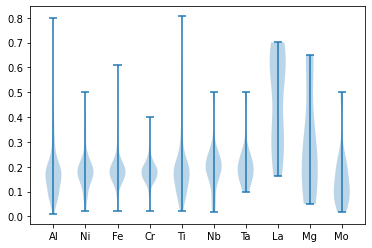

In [62]:
import seaborn as sns
el_atom_frac_dict = {}
for k in hea_phase_gen_dict.keys():
    test_inds = hea_phase_gen_dict[k]['test']
    temp_comps = [pmg_comps[i] for i in test_inds]
    el_atom_frac = [p.get_atomic_fraction(k) for p in temp_comps]
    el_atom_frac_dict[k] = el_atom_frac
plt.violinplot(list(el_atom_frac_dict.values()))
plt.xticks(np.arange(1,len(el_atom_frac_dict.keys())+1),el_atom_frac_dict.keys())

In [33]:
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
for method in methods:
    dev_list = []
    for key in LOEO_dict.keys():
        weight = (len(hea_phase_gen_dict[key]['test']))/len(comps)
        temp_dev = np.array(LOEO_dict[key][method]) - np.array(LOEO_dict[key]['baseline'])
        dev_list.append(temp_dev)
    dev_list = np.array(dev_list).flatten()
    print(f'Method : {method}, Mean : {np.mean(temp_dev)}, Std : {np.std(temp_dev)}')

Method : dense, Mean : -0.02552940095568227, Std : 0.010708125740306997
Method : atomic, Mean : 0.002075573146431231, Std : 0.00883782986595243
Method : random, Mean : -0.0033860977447647154, Std : 0.008754729884890719
Method : random-tr, Mean : -0.0021209687277175425, Std : 0.009036874198074897
Method : pettifor, Mean : 0.011747574704434882, Std : 0.00837470816499912
Method : mod_pettifor, Mean : -0.0029076064760545028, Std : 0.010379959680080517
Method : PTR, Mean : -0.004055428296385855, Std : 0.015900693290660864


In [10]:
test_df = pd.DataFrame.from_dict(LOEO_dict,orient='index')

def alternate_text(x):
    mean = np.round(np.mean(x),3)
    std = np.round(np.std(x),3)
    return ufloat(mean,std)

test_df = test_df.applymap(alternate_text)
test_df

,baseline,dense,atomic,random,random-tr,pettifor,mod_pettifor,PTR
Al,0.765+/-0.004,0.770+/-0.006,0.803+/-0.009,0.784+/-0.007,0.782+/-0.008,0.776+/-0.005,0.780+/-0.007,0.7740+/-0.0010
Ni,0.682+/-0.015,0.60+/-0.05,0.743+/-0.008,0.731+/-0.009,0.734+/-0.008,0.723+/-0.014,0.701+/-0.010,0.720+/-0.015
Fe,0.839+/-0.012,0.860+/-0.014,0.877+/-0.007,0.865+/-0.010,0.867+/-0.004,0.865+/-0.006,0.825+/-0.010,0.873+/-0.007
Cr,0.918+/-0.008,0.912+/-0.015,0.935+/-0.007,0.933+/-0.006,0.929+/-0.007,0.921+/-0.009,0.902+/-0.006,0.928+/-0.006
Ti,0.737+/-0.007,0.717+/-0.010,0.727+/-0.007,0.733+/-0.008,0.732+/-0.008,0.729+/-0.007,0.724+/-0.009,0.723+/-0.005
Nb,0.874+/-0.008,0.815+/-0.014,0.864+/-0.014,0.842+/-0.012,0.843+/-0.008,0.870+/-0.028,0.864+/-0.020,0.892+/-0.030
Ta,0.986+/-0.024,0.951+/-0.026,0.986+/-0.025,0.983+/-0.028,0.986+/-0.028,0.983+/-0.017,0.983+/-0.017,0.979+/-0.024
La,0.98+/-0.04,0.935+/-0.031,0.974+/-0.032,0.948+/-0.025,0.968+/-0.034,0.96+/-0.04,0.96+/-0,0.980+/-0.020
Mg,0.98+/-0.04,0.94+/-0.05,0.993+/-0.020,0.97+/-0.06,0.98+/-0.04,0.993+/-0.020,1.0+/-0,0.993+/-0.020
Mo,0.874+/-0.010,0.849+/-0.012,0.876+/-0.009,0.871+/-0.009,0.872+/-0.009,0.886+/-0.007,0.871+/-0.011,0.870+/-0.014


In [46]:
from scipy.stats import ttest_ind

for el in hea_phase_gen_dict.keys():
    for method in methods:
        p = ttest_ind(LOEO_dict[el][method], LOEO_dict[el]['baseline'])[-1]
        print(f'Element : {el},method : {method} , p value : {p}')

Element : Al,method : dense , p value : 0.038733719775459995
Element : Al,method : atomic , p value : 7.423514060252714e-10
Element : Al,method : random , p value : 1.9534969875060257e-06
Element : Al,method : random-tr , p value : 2.960752999159578e-05
Element : Al,method : pettifor , p value : 0.0001256246909892902
Element : Al,method : mod_pettifor , p value : 2.5459022129628125e-05
Element : Al,method : PTR , p value : 3.4239550718161905e-05
Element : Ni,method : dense , p value : 0.00017079886112306416
Element : Ni,method : atomic , p value : 2.6196074635657606e-09
Element : Ni,method : random , p value : 1.2661977461009023e-07
Element : Ni,method : random-tr , p value : 2.7840106473702498e-08
Element : Ni,method : pettifor , p value : 1.1743226593295514e-05
Element : Ni,method : mod_pettifor , p value : 0.007171226073433007
Element : Ni,method : PTR , p value : 5.1566692907299186e-05
Element : Fe,method : dense , p value : 0.0026568597969768774
Element : Fe,method : atomic , p va

In [45]:
ttest_ind(LOEO_dict[el][method], LOEO_dict[el]['baseline'])

Ttest_indResult(statistic=-5.007824027811641, pvalue=9.128283395595533e-05)

## Systems as holdout

In [64]:
from itertools import combinations
selected_els = ['Al','Ni','Fe','Cr','Ti','Nb','Ta','La','Mg','Mo']
ternary_combinations = list(combinations(selected_els,3))
ternary_dict = {}
for tc in ternary_combinations:
    binary = list(combinations(tc,2))
    ternary = list(combinations(tc,3))
    ind_list = []
    for i,c in enumerate(pmg_comps):
        el_list = list(c.get_el_amt_dict().keys())
        binary_el_list = list(combinations(el_list,2))
        if len(set(binary_el_list).intersection(binary)) != 0:
            ind_list.append(i)
    if len(ind_list)>=50:
        ternary_dict[tc] = ind_list

In [57]:
np.random.seed(0)
hea_phase_system_dict = {}
for tc in ternary_dict.keys():
    remove_inds = ternary_dict[tc]
    retain_inds = list(set(np.arange(len(comps))) - set(remove_inds))
    X_train = np.array(pmg_comps)[retain_inds]
    kf = StratifiedKFold(n_splits=10, random_state=0,shuffle=True).split(X_train,y[retain_inds])
    all_cv_train, all_cv_test = [] , []
    for tr, ts in kf:
        all_cv_train.append(tr.tolist())
        all_cv_test.append(ts.tolist())
    hea_phase_system_dict[tc] = {'cv_train':all_cv_train,'cv_test':all_cv_test,'holdout':remove_inds}

In [58]:
methods = ['baseline','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
dset = data_generator_vec(pymatgen_comp(comps))
LOSO_dict = {}
for k in hea_phase_system_dict.keys():
    LOSO_dict[k] = {}
    temp_dict = hea_phase_system_dict[k]
    holdout_test = temp_dict['holdout']
    cv_train, cv_test = temp_dict['cv_train'], temp_dict['cv_test']
    temp_dict = {}
    for i, method in enumerate(methods):
        score=[]
        fold_report = {}
        if method == 'baseline':
            features = dset.real_data
        else:
            if method == 'atomic':
                extracted = enc1d_features(pmg_comps,'atomic')
            elif method == 'random':
                extracted = enc1d_features(pmg_comps,'random')
            elif method == 'random-tr':
                extracted = enc1d_features(pmg_comps,'random-tr')
            elif method == 'pettifor':
                extracted = enc1d_features(pmg_comps,'pettifor')
            elif method == 'mod_pettifor':
                extracted = enc1d_features(pmg_comps,'mod_pettifor')
            elif method == 'PTR':
                extracted = get_PTR_features(pmg_comps)
            elif method =='dense':
                extracted = enc1d_features(pmg_comps,'dense')
            ind = component_dict[method]
            pca = PCA(n_components=ind, whiten=True)
            features = pca.fit_transform(extracted)
        model = baseline_model = RandomForestClassifier(random_state=0, n_jobs=-1)
        for i, (train_inds, test_inds) in enumerate(zip(*[cv_train,cv_test])):
                train_features = features[train_inds]
                train_y = y[train_inds]
                model.fit(train_features,train_y)
                yte_pred=baseline_model.predict(features[test_inds])
                yte_pred_holdout = baseline_model.predict(features[holdout_test])
                report = metrics.classification_report(y[holdout_test], yte_pred_holdout,output_dict=True)
                fold_micro_avg = report['weighted avg']['f1-score']
                score.append(fold_micro_avg)
                fold_report['Fold_{}'.format(k)] = report
        temp_dict[method] = score
        LOSO_dict[k] = LOSO_dict[k]|temp_dict

In [61]:
LOSO_dict.keys()

dict_keys([('Al', 'Ni', 'Fe'), ('Al', 'Ni', 'Cr'), ('Al', 'Ni', 'Ti'), ('Al', 'Ni', 'Nb'), ('Al', 'Ni', 'Ta'), ('Al', 'Ni', 'La'), ('Al', 'Ni', 'Mg'), ('Al', 'Ni', 'Mo'), ('Al', 'Fe', 'Cr'), ('Al', 'Fe', 'Ti'), ('Al', 'Fe', 'Nb'), ('Al', 'Fe', 'Ta'), ('Al', 'Fe', 'La'), ('Al', 'Fe', 'Mg'), ('Al', 'Fe', 'Mo'), ('Al', 'Cr', 'Ti'), ('Al', 'Cr', 'Nb'), ('Al', 'Cr', 'Ta'), ('Al', 'Cr', 'La'), ('Al', 'Cr', 'Mg'), ('Al', 'Cr', 'Mo'), ('Al', 'Ti', 'Nb'), ('Al', 'Ti', 'Ta'), ('Al', 'Ti', 'La'), ('Al', 'Ti', 'Mg'), ('Al', 'Ti', 'Mo'), ('Ni', 'Fe', 'Ti'), ('Ni', 'Cr', 'Ti'), ('Ni', 'Ti', 'Nb'), ('Ni', 'Ti', 'Ta'), ('Ni', 'Ti', 'La'), ('Ni', 'Ti', 'Mg'), ('Ni', 'Ti', 'Mo'), ('Fe', 'Cr', 'Ti'), ('Fe', 'Ti', 'Nb'), ('Fe', 'Ti', 'Ta'), ('Fe', 'Ti', 'La'), ('Fe', 'Ti', 'Mg'), ('Fe', 'Ti', 'Mo'), ('Cr', 'Ti', 'Nb'), ('Cr', 'Ti', 'Ta'), ('Cr', 'Ti', 'La'), ('Cr', 'Ti', 'Mg'), ('Cr', 'Ti', 'Mo')])

In [59]:
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
for method in methods:
    dev_list = []
    for key in LOSO_dict.keys():
        
        temp_dev = np.array(LOSO_dict[key][method]) - np.array(LOSO_dict[key]['baseline'])
        dev_list.append(temp_dev)
    dev_list = np.array(dev_list).flatten()
    print(f'Method : {method}, Mean : {np.mean(temp_dev)}, Std : {np.std(temp_dev)}')

Method : dense, Mean : -0.004222142412039875, Std : 0.010125651035610828
Method : atomic, Mean : 0.0013719850403033362, Std : 0.006981462845730592
Method : random, Mean : 9.31839792311595e-05, Std : 0.007187545863169533
Method : random-tr, Mean : 0.0029094956533980755, Std : 0.009375394596663254
Method : pettifor, Mean : 0.0019776846740841903, Std : 0.00946968481726214
Method : mod_pettifor, Mean : -0.0020626441648936345, Std : 0.0075776800707673736
Method : PTR, Mean : -0.004069049683494308, Std : 0.006717035870019577


In [60]:
test_df = pd.DataFrame.from_dict(LOSO_dict,orient='index')

def alternate_text(x):
    mean = np.round(np.mean(x),3)
    std = np.round(np.std(x),3)
    return ufloat(mean,std)

test_df = test_df.applymap(alternate_text)
test_df

baseline            dense           atomic           random  \
Al Ni Fe  0.7800+/-0.0030    0.799+/-0.009    0.829+/-0.006    0.801+/-0.007   
      Cr  0.7900+/-0.0030    0.799+/-0.012    0.837+/-0.008    0.813+/-0.008   
      Ti  0.7000+/-0.0020    0.723+/-0.010    0.738+/-0.008    0.729+/-0.008   
      Nb    0.783+/-0.004    0.788+/-0.011    0.818+/-0.007    0.804+/-0.006   
      Ta  0.7860+/-0.0020    0.794+/-0.008    0.822+/-0.005    0.798+/-0.005   
      La  0.7720+/-0.0020    0.793+/-0.009    0.817+/-0.013    0.793+/-0.007   
      Mg  0.7970+/-0.0020    0.814+/-0.012    0.843+/-0.006    0.821+/-0.008   
      Mo    0.779+/-0.004    0.800+/-0.010    0.820+/-0.006    0.799+/-0.005   
   Fe Cr    0.968+/-0.004  0.9660+/-0.0020  0.9760+/-0.0030  0.9700+/-0.0030   
      Ti    0.909+/-0.005    0.893+/-0.005  0.9210+/-0.0030  0.9150+/-0.0030   
      Nb    0.918+/-0.007    0.906+/-0.009    0.923+/-0.006    0.916+/-0.007   
      Ta    0.963+/-0.005    0.958+/-0.006    0.968+/-0.004    0.965+/-0.005   
      La  0.8550+/-0.0030    0.868+/-0.008  0.8990+/-0.0020    0.861+/-0.005   
      Mg  0.9690+/-0.0030    0.970+/-0.004  0.9750+/-0.0030  0.9720+/-0.0020   
      Mo    0.930+/-0.004    0.927+/-0.006  0.9350+/-0.0020    0.930+/-0.007   
   Cr Ti    0.925+/-0.006    0.925+/-0.005  0.9350+/-0.0030    0.937+/-0.004   
      Nb    0.972+/-0.006    0.968+/-0.008    0.968+/-0.005    0.975+/-0.006   
      Ta    0.991+/-0.009    0.983+/-0.011    0.985+/-0.004    0.994+/-0.008   
      La  0.8840+/-0.0030    0.887+/-0.004  0.9140+/-0.0030  0.8860+/-0.0030   
      Mg  0.9980+/-0.0030    0.990+/-0.007  0.9990+/-0.0030    0.998+/-0.004   
      Mo    0.957+/-0.008    0.946+/-0.009  0.9510+/-0.0030    0.955+/-0.005   
   Ti Nb    0.830+/-0.011    0.828+/-0.011    0.833+/-0.011    0.832+/-0.007   
      Ta    0.857+/-0.012    0.854+/-0.015    0.860+/-0.009    0.860+/-0.010   
      La    0.665+/-0.008    0.676+/-0.011    0.703+/-0.016    0.666+/-0.010   
      Mg    0.872+/-0.009    0.863+/-0.014    0.870+/-0.009    0.874+/-0.008   
      Mo    0.878+/-0.009    0.873+/-0.012    0.881+/-0.006    0.879+/-0.009   
Ni Fe Ti        0.617+/-0    0.641+/-0.014    0.637+/-0.009    0.624+/-0.009   
   Cr Ti    0.645+/-0.005    0.654+/-0.008    0.651+/-0.004    0.651+/-0.005   
   Ti Nb        0.576+/-0    0.602+/-0.014    0.596+/-0.010    0.587+/-0.009   
      Ta        0.582+/-0    0.607+/-0.013    0.604+/-0.008    0.596+/-0.010   
      La        0.576+/-0    0.602+/-0.014    0.596+/-0.010    0.587+/-0.009   
      Mg        0.576+/-0    0.602+/-0.014    0.596+/-0.010    0.587+/-0.009   
      Mo        0.576+/-0    0.602+/-0.014    0.596+/-0.010    0.587+/-0.009   
Fe Cr Ti    0.995+/-0.008    0.992+/-0.011    0.995+/-0.007    0.997+/-0.006   
   Ti Nb  0.9340+/-0.0020  0.9010+/-0.0030  0.9340+/-0.0020  0.9020+/-0.0020   
      Ta          1.0+/-0    0.998+/-0.004          1.0+/-0    0.997+/-0.004   
      La          1.0+/-0    0.997+/-0.004          1.0+/-0    0.998+/-0.004   
      Mg          1.0+/-0    0.997+/-0.004          1.0+/-0    0.998+/-0.004   
      Mo    0.914+/-0.005    0.915+/-0.009  0.9170+/-0.0030    0.908+/-0.007   
Cr Ti Nb    0.997+/-0.010    0.988+/-0.011    0.996+/-0.009    0.995+/-0.007   
      Ta    0.996+/-0.011    0.988+/-0.011    0.994+/-0.009    0.993+/-0.008   
      La    0.996+/-0.008    0.993+/-0.009    0.995+/-0.011    0.997+/-0.006   
      Mg    0.996+/-0.008    0.993+/-0.009    0.995+/-0.011    0.997+/-0.006   
      Mo    0.944+/-0.011    0.940+/-0.012    0.946+/-0.008    0.945+/-0.008   

                random-tr         pettifor     mod_pettifor              PTR  
Al Ni Fe  0.7910+/-0.0030    0.790+/-0.005  0.7850+/-0.0020    0.794+/-0.007  
      Cr    0.808+/-0.005    0.799+/-0.004    0.800+/-0.005    0.804+/-0.010  
      Ti    0.704+/-0.009    0.714+/-0.008    0.710+/-0.006    0.708+/-0.004  
      Nb    0.802+/-0.004    0.799+/-0.006    0.796+/-0.008    0.795+/-0.004  
      Ta    0.795+/-0